In [1]:
import os

import numpy as np
import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

## Functions

In [117]:
def rgb_to_grayscale_luminosity(image):
    """
    Convert an RGB image to grayscale using luminosity method.

    Parameters:
        image: Input RGB image (numpy array or equivalent).

    Returns:
        grayscale_image: Grayscale image (numpy array or equivalent).
    """
    # Get the dimensions of the input image
    img_array = np.array(image)
    height, width, channels = img_array.shape

    # Create an empty array for the grayscale image
    grayscale_image = np.zeros((height, width), dtype=np.uint8)

    # Iterate over each pixel in the image
    for y in range(height):
        for x in range(width):
            # Extract the RGB values of the pixel
            r, g, b = img_array[y, x]

            # Calculate luminosity
            # luminosity = 0.21 * r + 0.72 * g + 0.07 * b
            luminosity = 0.299 * r + 0.587 * g + 0.114 * b
            # Set the grayscale pixel value
            grayscale_image[y, x] = int(luminosity)

    grayscale_image = Image.fromarray(grayscale_image)
    return grayscale_image


In [109]:
def adaptive_thresholding(image: Image, block_size=3, offset=0):
    '''
    pixels below a certain value -> black
    pixels above a certain value -> white
    '''
    grayscale_img = image.convert('L')
    img_array = np.array(grayscale_img)
    height, width = img_array.shape

    #an empty array for the output
    thresholded_image = np.zeros((height, width))
    
    for y in range(0,height, block_size):
        for x in range(0, width, block_size):
            block = img_array[y:y+block_size, x:x+block_size]
            #find the mean
            block_mean = np.mean(block)
            thresholded_block = (block > (block_mean-offset)).astype(np.uint8)*255
            thresholded_image[y:y+block_size, x:x+block_size] = thresholded_block
    return Image.fromarray(thresholded_image)

In [110]:
import numpy as np
from PIL import Image

def adaptive_thresholdMean(image, block_size, c):
    """
    Apply Adaptive Mean Thresholding to the input grayscale image.

    Parameters:
        image: Input grayscale image (PIL Image object).
        block_size: Size of the local neighborhood for threshold calculation.
        c: Constant subtracted from the mean to obtain the threshold value.

    Returns:
        thresholded_image: Thresholded image (PIL Image object).
    """
    # Convert PIL Image to numpy array
    grayscale_img = rgb_to_grayscale_luminosity(image)
    img_array = np.array(grayscale_img)

    # Get image dimensions
    height, width = img_array.shape

    # Create an empty array for the output
    thresholded_image = np.zeros((height, width))

    # Apply adaptive thresholding
    for i in range(height):
        for j in range(width):
            # Calculate block boundaries
            x_min = max(0, i - block_size // 2)
            y_min = max(0, j - block_size // 2)
            x_max = min(height - 1, i + block_size // 2)
            y_max = min(width - 1, j + block_size // 2)
            
            # Extract block from image
            block = img_array[x_min:x_max+1, y_min:y_max+1]
            
            # Calculate threshold
            thresh = np.mean(block) - c
            
            # Apply thresholding
            if img_array[i, j] >= thresh:
                thresholded_image[i, j] = 255
            else:
                thresholded_image[i, j] = 0

    # Convert thresholded numpy array back to PIL Image
    thresholded_image = Image.fromarray(thresholded_image)

    return thresholded_image


In [111]:
def negate(image):
    '''
    White background, black text -> black background, white text
    '''
    img_arr = np.array(image)
    # img_arr[img_arr == 0] = np.uint8(255)
    height, width = img_arr.shape
    for y in range(height):
        for x in range(width):
            img_arr[y,x] = (img_arr[y,x]==0).astype(np.uint8)*255
    return Image.fromarray(img_arr)

In [112]:
def show(image):
    '''
    convert the image to PIL image and show.
    '''
    if isinstance(image, np.ndarray):
        Image.fromarray(image).show()
    elif isinstance(image, Image.Image):
        image.show()
    else:
        print("Can't show image.")
    

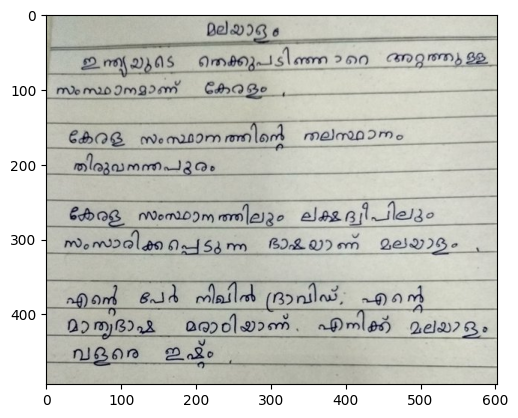

In [184]:
image_path = 'mal-hw.jpeg'
img = Image.open(image_path)
plt.imshow(img)

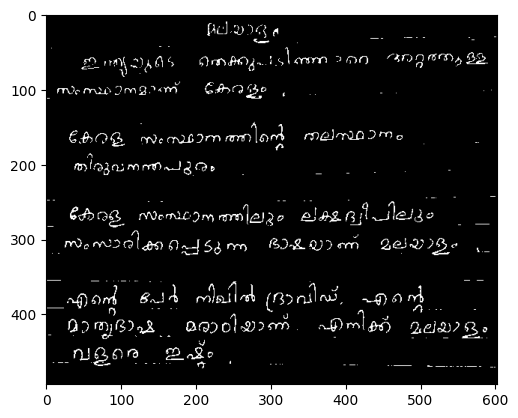

In [186]:
thresh_img = adaptive_thresholdMean(img, 50, 80)
thresh_img = negate(thresh_img)
plt.imshow(thresh_img)

In [187]:
type(thresh_img)

PIL.Image.Image

In [188]:
# Assuming thresh_img is a PIL.Image.Image object
thresh_img = np.asarray(thresh_img)

In [189]:
type(thresh_img)

numpy.ndarray

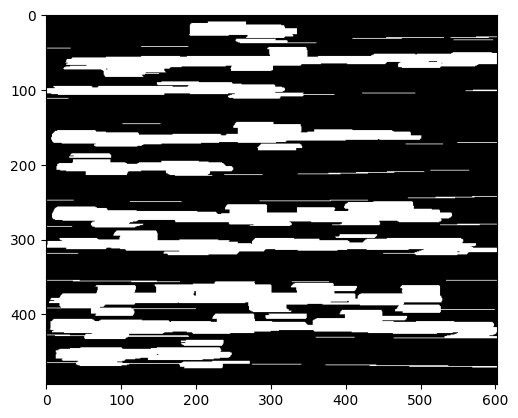

In [190]:
# dilation
kernel = np.ones((1,50),np.uint8)
dilated_img = cv2.dilate(thresh_img,kernel,iterations = 1)
plt.imshow(dilated_img,cmap='gray')

In [191]:
type(dilated_img)

numpy.ndarray

In [192]:
# Convert the dilated image to a suitable format for contour detection
dilated_img_uint8 = dilated_img.astype(np.uint8)

# Find contours
contours, hierarchy = cv2.findContours(dilated_img_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by y-coordinate
sorted_contours_lines = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[1])


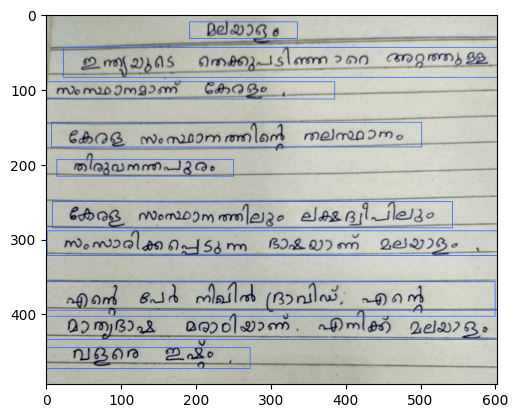

In [193]:
img2 = np.array(img.copy())
for ctr in sorted_contours_lines:
    
    if cv2.contourArea(ctr)<1000:
        continue

    x,y,w,h = cv2.boundingRect(ctr)
    cv2.rectangle(img2, (x,y), (x+w,y+h),(40, 100, 250) ,1)

plt.imshow(img2)

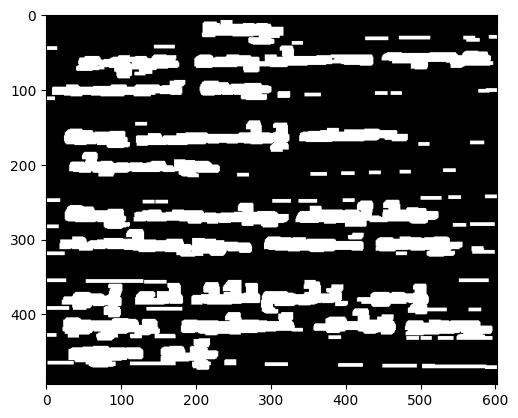

In [194]:
# dilation
kernel = np.ones((5,15),np.uint8)
dilated2_img = cv2.dilate(thresh_img,kernel,iterations = 1)
plt.imshow(dilated2_img,cmap='gray')

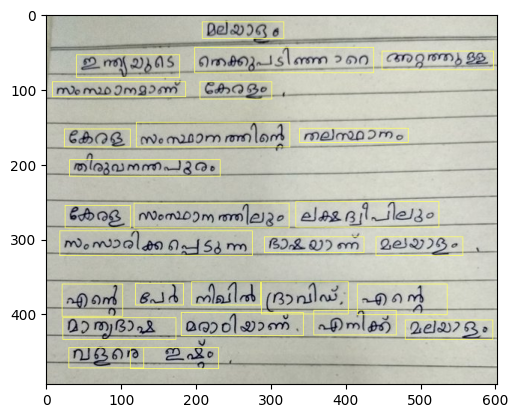

In [195]:
img3 = np.array(img.copy())
word_list = []

# Convert the dilated image to a suitable format for contour detection
dilated2_img_uint8 = dilated2_img.astype(np.uint8)

for line in sorted_contours_lines:

    # roi of each line
    x,y,w,h = cv2.boundingRect(line)
    roi_line = dilated2_img_uint8[y:y+h,x:x+w]

    # draw contours on each word
    (cnt,hierarchy) = cv2.findContours(roi_line.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    sorted_contours_words = sorted(cnt,key = lambda cntr : cv2.boundingRect(cntr)[0])

    for word in sorted_contours_words:

        if cv2.contourArea(word)<600:
            continue
            
        x2,y2,w2,h2 = cv2.boundingRect(word)
        word_list.append([x+x2,y+y2,x+x2+w2,y+y2+h2])
        cv2.rectangle(img3, (x+x2,y+y2), (x+x2+w2,y+y2+h2), (255, 255, 100) ,1)

plt.imshow(img3)

## Character Segementation

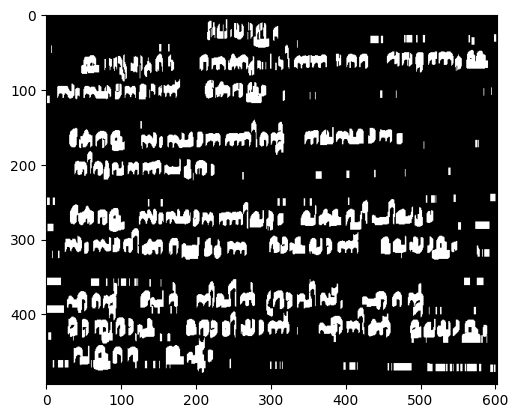

In [196]:
# dilation
kernel = np.ones((4,1),np.uint8)
dilated3_img = cv2.dilate(thresh_img,kernel,iterations = 3)
plt.imshow(dilated3_img,cmap='gray')

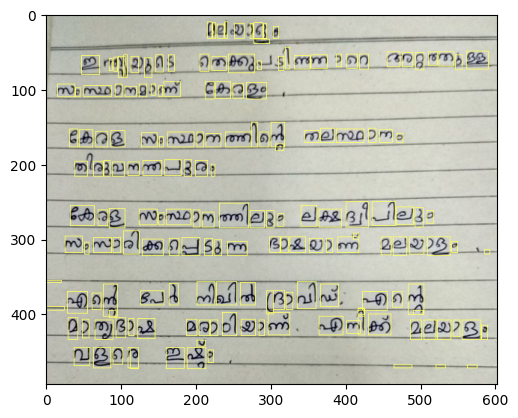

In [197]:
img4 = np.array(img.copy())
char_list = []

# Convert the dilated image to a suitable format for contour detection
dilated3_img_uint8 = dilated3_img.astype(np.uint8)

for line in sorted_contours_lines:
    # roi of each line
    x,y,w,h = cv2.boundingRect(line)
    roi_line = dilated2_img_uint8[y:y+h, x:x+w]

    # draw contours on each word
    (contours, _) = cv2.findContours(roi_line.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours_words = sorted(contours, key=lambda cntr: cv2.boundingRect(cntr)[0])

    for word in sorted_contours_words:
        # roi of each word
        x1, y1, w1, h1 = cv2.boundingRect(word)
        roi_word = dilated3_img_uint8[y+y1:y+y1+h1, x+x1:x+x1+w1]  # Corrected ROI indexing

        # draw contours on each character
        (char_contours, _) = cv2.findContours(roi_word.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        sorted_contours_chars = sorted(char_contours, key=lambda cntr: cv2.boundingRect(cntr)[0])

        for char in sorted_contours_chars:
            if cv2.contourArea(char) < 30:
                continue

            x2, y2, w2, h2 = cv2.boundingRect(char)
            char_list.append([x+x1+x2, y+y1+y2, x+x1+x2+w2, y+y1+y2+h2])  # Corrected bounding box coordinates
            cv2.rectangle(img4, (x+x1+x2, y+y1+y2), (x+x1+x2+w2, y+y1+y2+h2), (255, 255, 100), 1)  # Corrected rectangle coordinates

plt.imshow(img4)